In [1]:
import sys
from pathlib import Path

script_dir = Path().resolve()
root_dir = (script_dir.parent)
sys.path.append(str(root_dir))
sys.path.append(str(root_dir.parent))

from endata.data_generator import DataGenerator

/home/fuest/EnData/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating a Data Generator and loading a pre-trained model ##

The first step towards creating synthetic time series data is to load a model. In this instance, we will load a pre-trained ACGAN trained on the PecanStreet dataset. In order to do this, you will first need to initialize a data generator.

In [2]:
generator = DataGenerator(model_name="acgan")

The code snippet above initializes an untrained ACGAN. In order to load an appropriate pre-trained model checkpoint, you will need to explicitly load the model checkpoint provided:

In [3]:
generator.load_model(dataset_name="pecanstreet")

[EnData] Loading full checkpoint (weights + metadata) from /home/fuest/.cache/endata/checkpoints/pecanstreet/acgan/pecanstreet_acgan_dim1.ckpt. Use `.pt` for safer minimal loading.


## Generating synthetic data ##

All pre-trained models in EnData are conditional generative models. This means that the user has to specify the context variables for which the generator generates data. To view the required context variables, each generator instance has a function that outputs the available context variables and the corresponding integer codes:

In [4]:
generator._read_ctx_codes("pecanstreet")

{'month': {0: 'January',
  1: 'February',
  2: 'March',
  3: 'April',
  4: 'May',
  5: 'June',
  6: 'July',
  7: 'August',
  8: 'September',
  9: 'October',
  10: 'November',
  11: 'December'},
 'weekday': {0: 'Monday',
  1: 'Tuesday',
  2: 'Wednesday',
  3: 'Thursday',
  4: 'Friday',
  5: 'Saturday',
  6: 'Sunday'},
 'building_type': {0: 'Apartment',
  1: 'Single-Family Home 001 (Master)',
  2: 'Town Home'},
 'has_solar': {0: 'no', 1: 'yes'},
 'car1': {0: 'no', 1: 'yes'},
 'city': {0: 'Austin',
  1: 'Brooktondale',
  2: 'Groton',
  3: 'Ithaca',
  4: 'Lansing',
  5: 'San Diego',
  6: 'Trumansburg'},
 'state': {0: 'California', 1: 'New York', 2: 'Texas'},
 'total_square_footage': {0: '(1070.324, 2010.0]',
  1: '(2010.0, 2945.0]',
  2: '(2945.0, 3880.0]',
  3: '(3880.0, 4815.0]',
  4: '(4815.0, 5750.0]'},
 'house_construction_year': {0: '(1796.7830000000001, 1840.2]',
  1: '(1840.2, 1883.4]',
  2: '(1883.4, 1926.6]',
  3: '(1926.6, 1969.8]',
  4: '(1969.8, 2013.0]'}}

We will now specify the desired conditions in a Python dictionary, and pass those to the data generator, along with the desired number of samples. The samples arg refers to the number of synthetic timeseries with the datasets specified sequence length that the model will generate. It does not refer to the number of measurement values.

In [5]:
cond_vars = {
    "weekday": 1, # Monday
    "month": 2, # January
    "building_type": 0, # Apartment
    "city": 0, # Austin
    "state": 2, # Texas
    "house_construction_year": 3, # between 1969 and 2013
    "total_square_footage": 0, # between 1070 and 2010 sq feet
    "car1": 0, # no ev
    "has_solar": 0, # no solar panels
}

generator.set_context(**cond_vars)
data = generator.generate(n=2)
data

,weekday,month,building_type,city,state,house_construction_year,total_square_footage,car1,has_solar,grid
0,1,2,0,0,2,3,0,0,0,"[0.4297207, 0.5775695, 0.7106424, 0.3975546, 0..."
1,1,2,0,0,2,3,0,0,0,"[0.43247467, 0.5827502, 0.71375954, 0.3932764,..."


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from endata.eval.eval_utils import get_hourly_ticks

syn_data = generator.generate(n=100)
syn_data_array = np.stack(syn_data["grid"].values)
syn_data

,weekday,month,building_type,city,state,house_construction_year,total_square_footage,car1,has_solar,grid
0,1,2,0,0,2,3,0,0,0,"[0.42506382, 0.5764654, 0.6984965, 0.39963993,..."
1,1,2,0,0,2,3,0,0,0,"[0.42475802, 0.57061577, 0.695419, 0.39422497,..."
2,1,2,0,0,2,3,0,0,0,"[0.42994317, 0.57612026, 0.7039622, 0.393195, ..."
3,1,2,0,0,2,3,0,0,0,"[0.43098807, 0.579445, 0.7037719, 0.39751193, ..."
4,1,2,0,0,2,3,0,0,0,"[0.43027836, 0.58011603, 0.70846665, 0.3973686..."
...,...,...,...,...,...,...,...,...,...,...
95,1,2,0,0,2,3,0,0,0,"[0.42554033, 0.5785848, 0.71288943, 0.39836848..."
96,1,2,0,0,2,3,0,0,0,"[0.4294537, 0.5796326, 0.7193018, 0.39725062, ..."
97,1,2,0,0,2,3,0,0,0,"[0.425824, 0.57904124, 0.7076802, 0.39121044, ..."
98,1,2,0,0,2,3,0,0,0,"[0.42813957, 0.57091093, 0.7014352, 0.39445212..."


/tmp/ipykernel_350113/2139003100.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


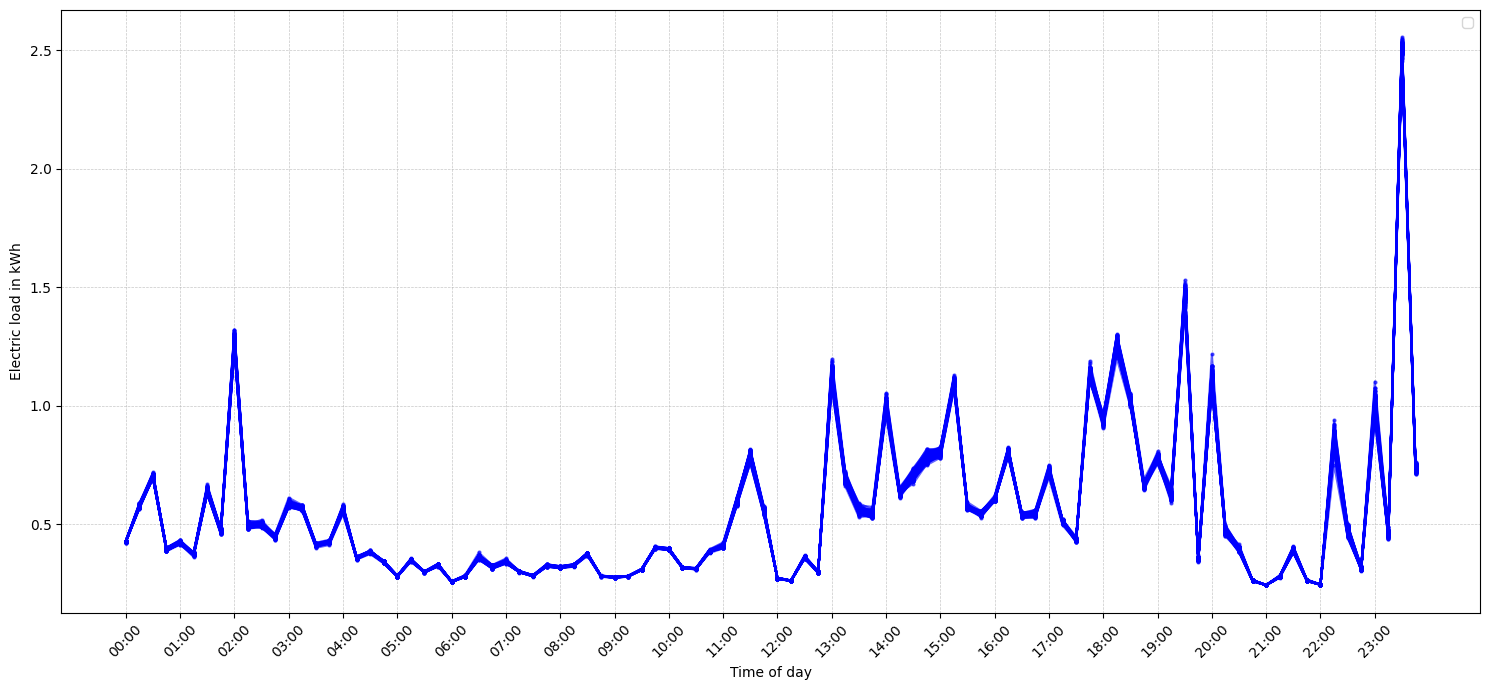

In [7]:
timestamps = pd.date_range(start="00:00", end="23:45", freq="15min")
hourly_positions, hourly_labels = get_hourly_ticks(timestamps)
plt.figure(figsize=(15, 7))
if syn_data_array.ndim == 3 and syn_data_array.shape[2] == 2:
    for index in range(syn_data_array.shape[0]):
        plt.plot(
            range(len(timestamps)),
            syn_data_array[index, :, 0],
            color="blue",
            marker="o",
            markersize=2,
            linestyle="-",
            alpha=0.6,
            label="Electricity net consumption" if index == 0 else None,
        )

        plt.plot(
            range(len(timestamps)),
            syn_data_array[index, :, 1],
            color="orange",
            marker="o",
            markersize=2,
            linestyle="-",
            alpha=0.6,
            label="Electricity generation" if index == 0 else None,
        )
else:
    for index in range(syn_data_array.shape[0]):
        plt.plot(
            range(len(timestamps)),
            syn_data_array[index].squeeze(),
            color="blue",
            marker="o",
            markersize=2,
            linestyle="-",
            alpha=0.6,
        )

plt.xlabel("Time of day")
plt.ylabel("Electric load in kWh")
plt.xticks(ticks=hourly_positions, labels=hourly_labels, rotation=45)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()